# Classification modeling
---

For my baseline model, I need to ask myself what I'm actually trying to do and whether my audience cares more about accuracy or interpretation. In academic settings and Earth sciences, I prefer to prioritize interpretation since I'm working with real-world concepts and I'd like to be able to use these methods to learn about the oceanographic processes at play here. For this reason, I'll be using scikit-learn's Logistic Regression model, a straightforward classification model that prioritizes interpretability over accuracy. There are several assumptions we make about our data when we use this model, including assuming that our independent variables are independent *of each other*. 

However, I know this isn't the case in my data and the variables are strongly correlated with each other. Out of curiosity, I'm going to make a model with each feature individually as one way to avoid the multicollinearity, and then use polynomial features to engineer some interaction features and utilize regularization techniques to reduce the effect of multicollinearity. 

In [150]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

random.seed(42)

---
### Load the data

In [2]:
df = pd.read_csv('../../coastal_upwelling_output/clean_dataframe.csv')

In [3]:
df

,time,density,practical_salinity,seawater_temperature,sea_surface_temperature,CUTI,upwelling
0,2017-01-01 00:00:00,1027.258767,33.916755,7.766451,11.273,1.731,1
1,2017-01-01 00:01:00,1027.260164,33.917475,7.760876,11.268,1.731,1
2,2017-01-01 00:02:00,1027.258920,33.917249,7.767207,11.267,1.731,1
3,2017-01-01 00:03:00,1027.258097,33.916964,7.771317,11.267,1.731,1
4,2017-01-01 00:04:00,1027.258173,33.917076,7.771017,11.278,1.731,1
...,...,...,...,...,...,...,...
329194,2017-09-15 23:55:00,1027.366397,33.960043,7.866675,15.198,-0.194,0
329195,2017-09-15 23:56:00,1027.366555,33.960125,7.866182,15.171,-0.194,0
329196,2017-09-15 23:57:00,1027.365319,33.959667,7.872284,15.158,-0.194,0
329197,2017-09-15 23:58:00,1027.364325,33.959192,7.876495,15.199,-0.194,0


This dataframe is over 300,000 observations, which I'm hesitant to pass to a model right away. I'm going to resample down to a small size at first, and then add data back in once the workflow is established.

In [4]:
df['time'] = pd.to_datetime(df['time'])

In [5]:
df_resampled = df.resample('20T', on='time').mean().dropna(how='all').reset_index().drop(columns=['time', 'CUTI', 'density'])
print(df_resampled.shape)

(17714, 4)


In [6]:
df_resampled

,practical_salinity,seawater_temperature,sea_surface_temperature,upwelling
0,33.917802,7.768099,11.27030,1.0
1,33.923736,7.695256,11.26795,1.0
2,33.925383,7.688413,11.26675,1.0
3,33.926747,7.698557,11.26465,1.0
4,33.916462,7.764130,11.26475,1.0
...,...,...,...,...
17709,33.948736,8.005974,15.24465,0.0
17710,33.946218,8.028650,15.25365,0.0
17711,33.953680,7.949766,15.22895,0.0
17712,33.942572,8.052701,15.17020,0.0


---
### Checking feature correlation

One of the big assumptions we make when building logistic regression models is that our independent features are independent of each other. We can print out a heatmap to check whether our features are correlated to each other or not.

<AxesSubplot:>

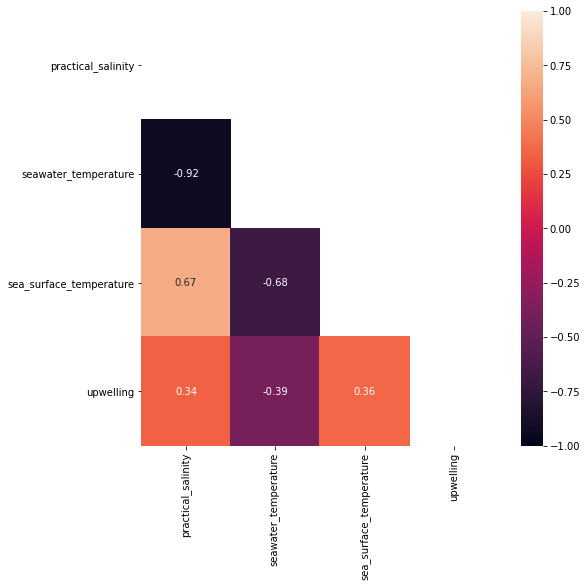

In [7]:
plt.figure(figsize=(8,8))

corr = df_resampled.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(df_resampled.corr(), annot=True, vmin=-1, vmax=1, mask=mask);

Yup, looks like our features are correlated with each other! We can also tell from this heatmap that seawater temperature collected by the 200 meter platform is most strongly correlated to upwelling of all our features. I'll build a logistic regression model without addressing the multicollinearity first, and then attempt to improve it by using PolynomialFeatures and ridge and lasso penalties. 

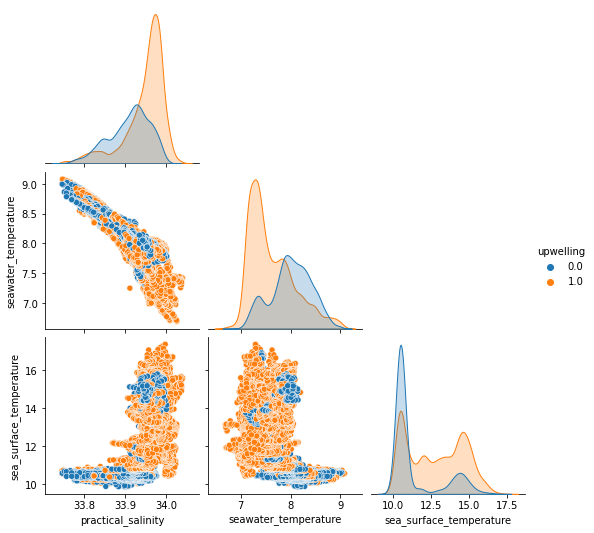

In [8]:
sns.pairplot(df_resampled, corner=True, hue='upwelling');

---
### Using only one feature

This sections is on building a model with only seawater temperature from the 200 meter platform as the prediction.

In [9]:
X = df_resampled['seawater_temperature']
y = df_resampled['upwelling']

y.value_counts(normalize=True)

1.0    0.61951
0.0    0.38049
Name: upwelling, dtype: float64

If we created a null model that labeled all predictions as the majority class, we'd be correct about 61.96% of the time! This is the accuracy I'm hoping to beat with logistic regression or decision tree models.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Create a pipeline with StandardScaler and LogisticRegression

In [11]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression())
])

In [12]:
pipe.fit(X_train.values.reshape(-1, 1), y_train)

Pipeline(steps=[('sc', StandardScaler()), ('logreg', LogisticRegression())])

In [13]:
print(f'Train accuracy: {pipe.score(X_train.values.reshape(-1, 1), y_train)}')
print(f'Test accuracy: {pipe.score(X_test.values.reshape(-1, 1), y_test)}')

Train accuracy: 0.689499435453519
Test accuracy: 0.6884172499435538


In [14]:
logreg = pipe.named_steps['logreg']
print(f'LogReg Intercept: {logreg.intercept_}')
print(f'LogReg Coef: {logreg.coef_}')

LogReg Intercept: [0.56096136]
LogReg Coef: [[-0.89346893]]


In [15]:
print(cross_val_score(pipe, X_train.values.reshape(-1, 1), y_train).mean())
print(cross_val_score(pipe, X_test.values.reshape(-1, 1), y_test).mean())

0.689951072638314
0.6884159110328907


This model performs better than our baseline, woohoo! But maybe we can do better with polynomial features.

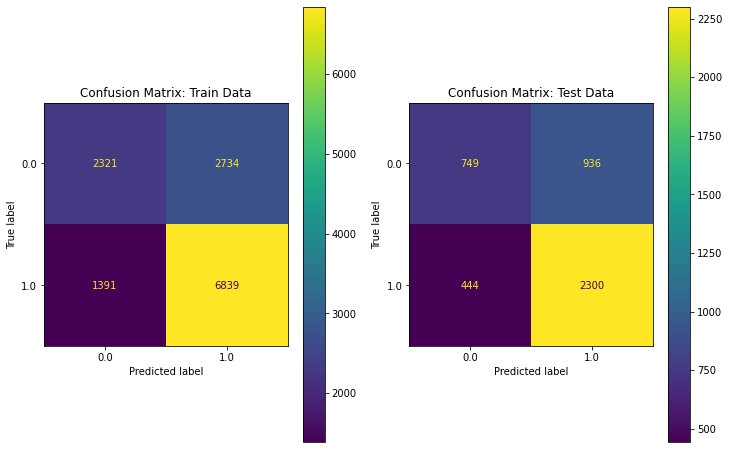

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

plot_confusion_matrix(pipe, X_train.values.reshape(-1, 1), y_train, ax=ax1)
ax1.set_title('Confusion Matrix: Train Data')

plot_confusion_matrix(pipe, X_test.values.reshape(-1, 1), y_test, ax=ax2)
ax2.set_title('Confusion Matrix: Test Data');

In [17]:
test_preds = pipe.predict(X_test.values.reshape(-1, 1))
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

         0.0       0.63      0.44      0.52      1685
         1.0       0.71      0.84      0.77      2744

    accuracy                           0.69      4429
   macro avg       0.67      0.64      0.64      4429
weighted avg       0.68      0.69      0.67      4429



---
### Using PolynomialFeatures

Now let's add those features back in and use feature interactions combined with regularization to try upping the accuracy while accounting for the multicollinearity.

An easy way to get a variety of feature interactions is using sklearn's PolynomialFeatures function. There are four features in this model, so I'll set the degree to 4 so that there will be an engineered feature that includes all 4 of the original features. 

In [44]:
X = df_resampled.drop(columns=['upwelling'])
y = df_resampled['upwelling']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [46]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=4, interaction_only=False, include_bias=False)),
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [47]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=4, include_bias=False)),
                ('sc', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000))])

In [48]:
print(f'Train accuracy: {pipe.score(X_train, y_train)}')
print(f'Test accuracy: {pipe.score(X_test, y_test)}')

Train accuracy: 0.7441475348136997
Test accuracy: 0.7520885075637842


In [156]:
pipe.pipe.named_steps['poly']

TypeError: list indices must be integers or slices, not str

In [154]:
#X_poly = poly.fit_transform(X)
pipe.steps.get_feature_names(X.columns)

['practical_salinity',
 'seawater_temperature',
 'sea_surface_temperature',
 'practical_salinity^2',
 'practical_salinity seawater_temperature',
 'practical_salinity sea_surface_temperature',
 'seawater_temperature^2',
 'seawater_temperature sea_surface_temperature',
 'sea_surface_temperature^2']

Question to self: do the coefficients need to be exponentiated to get their actual values, since the logistic regression model uses the logit function to transform the data?

In [51]:
X_poly.shape

(17714, 9)

Scale the data again!

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, stratify=y, random_state=42)

In [53]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [54]:
logreg = LogisticRegression(solver='liblinear')

In [55]:
logreg_params = {
    'penalty':['l1', 'l2'],
    'C': np.linspace(0.001, 1, 10)
}

In [56]:
gs = GridSearchCV(logreg, logreg_params, cv=5, verbose=2)

In [57]:
gs.fit(X_train_sc, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.112, penalty=l1; total time=   0.7s
[CV] END ................................C=0.11

KeyboardInterrupt: 

In [ ]:
print(f'Best parameters: {gs.best_params_}')
print(f'Best score: {gs.best_score_}')

Now that we have the best parameters, we can create a logistic regression model with these parameters and see what the coefficients are for our poly features.

In [ ]:
logreg3 = LogisticRegression(C=.334, solver='liblinear', penalty='l2')

In [ ]:
logreg3.fit(X_train_sc, y_train)

In [ ]:
print(f'LogReg Intercept: {logreg3.intercept_}')
print(f'LogReg Coef: {logreg3.coef_}')

In [ ]:
X

In [32]:
logreg3.coef_[0]

array([ 0.05463415, -0.062148  , -0.70540433,  0.10580061,  0.05672328,
       -0.04736196, -0.70958883,  0.1074085 , -0.0055321 , -0.80222133,
        0.1486707 ,  0.08738078, -0.00591653, -0.47797744,  0.05881218,
       -0.03418924, -0.7137793 ,  0.10901718,  0.00351988, -0.80649152,
        0.15030562,  0.08429796, -0.00487551, -0.47610615,  0.05110224,
       -0.90056968,  0.19196895,  0.00815977,  0.01591296, -0.43464806,
        0.95606905,  0.44133429, -0.49074913, -0.21949425,  0.06090085,
       -0.02234978, -0.71797579,  0.11062663,  0.01209778, -0.81076804,
        0.15194125,  0.08121444, -0.00383153, -0.47423477,  0.05815368,
       -0.90493032,  0.19362989,  0.00506458,  0.01702491, -0.43276673,
        0.95324626,  0.44089685, -0.48898002, -0.21757748,  0.10775485,
       -1.00051128,  0.23568006, -0.0714316 ,  0.03888975, -0.3911471 ,
        0.88194348,  0.42405695, -0.45506879, -0.17849178,  1.90021848,
        1.34530575, -0.3265769 , -0.16207072,  0.95937312])

In [33]:
list(zip(poly.get_feature_names(X.columns), logreg3.coef_[0])).sort()

In [34]:
sorted(list(zip(poly.get_feature_names(X.columns), logreg3.coef_[0])), key=lambda x: x[1])[:10]

[('practical_salinity^3 seawater_temperature', -1.0005112761681618),
 ('density practical_salinity^2 seawater_temperature', -0.9049303177305303),
 ('practical_salinity^2 seawater_temperature', -0.9005696810455995),
 ('density^2 practical_salinity seawater_temperature', -0.810768036913024),
 ('density practical_salinity seawater_temperature', -0.8064915229612897),
 ('practical_salinity seawater_temperature', -0.8022213319904652),
 ('density^3 seawater_temperature', -0.7179757943571895),
 ('density^2 seawater_temperature', -0.713779304463597),
 ('density seawater_temperature', -0.7095888250197461),
 ('seawater_temperature', -0.7054043300216676)]

In [35]:
sorted(list(zip(poly.get_feature_names(X.columns), logreg3.coef_[0])), key=lambda x: x[1])[-10:]

[('practical_salinity^3 sea_surface_temperature', 0.23568006172144354),
 ('practical_salinity seawater_temperature^2 sea_surface_temperature',
  0.4240569500531106),
 ('density seawater_temperature^2 sea_surface_temperature',
  0.44089684594289413),
 ('seawater_temperature^2 sea_surface_temperature', 0.44133428993578866),
 ('practical_salinity seawater_temperature^3', 0.8819434763219793),
 ('density seawater_temperature^3', 0.9532462596580414),
 ('seawater_temperature^3', 0.9560690511673234),
 ('sea_surface_temperature^4', 0.959373124870772),
 ('seawater_temperature^3 sea_surface_temperature', 1.3453057462692326),
 ('seawater_temperature^4', 1.9002184769307089)]

In [36]:
print(f'Train accuracy: {logreg3.score(X_train_sc, y_train)}')
print(f'Test accuracy: {logreg3.score(X_test_sc, y_test)}')

Train accuracy: 0.744824990590892
Test accuracy: 0.7520885075637842


In [ ]:
print(cross_val_score(logreg3, X_train_sc, y_train).mean())
print(cross_val_score(logreg3, X_test_sc, y_test).mean())

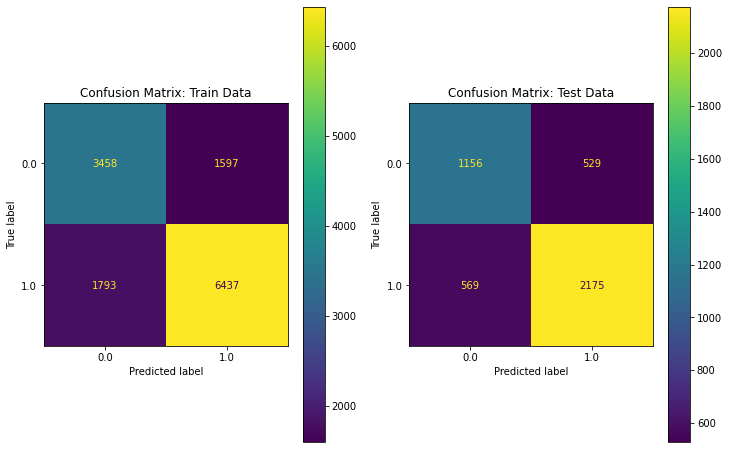

In [37]:
v

Looks like our false negatives outnumber our false positive

In [39]:
test_preds = logreg3.predict(X_test_sc)
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68      1685
         1.0       0.80      0.79      0.80      2744

    accuracy                           0.75      4429
   macro avg       0.74      0.74      0.74      4429
weighted avg       0.75      0.75      0.75      4429



# TODO:

Next will be trying to build a decision tree classifier as an alternative classification model that comes with interpretability. I'll also need to come back and reconsider everything I did above, there might be changes to make.

---
### Decision trees
Decision trees come in a lot of different shapes, so it'd be best to use GridSearchCV to find the best parameters for a tree for upwelling classification.

In [126]:
X = df_resampled.drop(columns=['upwelling'])
y = df_resampled['upwelling']

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [136]:
param_grid = {
    'max_depth': [5, 7, 9],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'ccp_alpha': [0, 0.01, 0.1, 1, 10]
}

In [137]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(),
                 param_grid=param_grid,
                 verbose=1,
                 cv=5)

In [138]:
%time gs.fit(X_train, y_train)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Wall time: 1min 38s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0, 0.01, 0.1, 1, 10],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 9],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [5, 10, 15, 20],
                         'splitter': ['best', 'random']},
             verbose=1)

In [139]:
gs.best_estimator_

DecisionTreeClassifier(ccp_alpha=0, max_depth=9, min_samples_leaf=5,
                       min_samples_split=20)

In [140]:
print(f'Score on training set: {gs.score(X_train, y_train)}')
print(f'Score on testing set: {gs.score(X_test, y_test)}')

Score on training set: 0.8188934888972526
Score on testing set: 0.7940844434409573


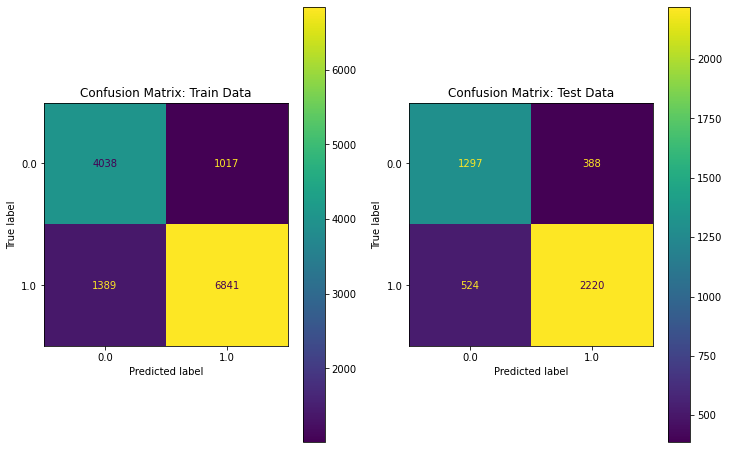

In [135]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

plot_confusion_matrix(gs, X_train, y_train, ax=ax1)
ax1.set_title('Confusion Matrix: Train Data')

plot_confusion_matrix(gs, X_test, y_test, ax=ax2)
ax2.set_title('Confusion Matrix: Test Data');

In [149]:
print(gs.best_estimator_.feature_importances_)
list(X_train.columns)

[0.13858473 0.1428204  0.71859487]


['practical_salinity', 'seawater_temperature', 'sea_surface_temperature']

In [85]:
print(export_text(gs.best_estimator_,
                  list(X_train.columns)));

|--- sea_surface_temperature <= 11.01
|   |--- seawater_temperature <= 8.79
|   |   |--- sea_surface_temperature <= 10.83
|   |   |   |--- sea_surface_temperature <= 10.52
|   |   |   |   |--- practical_salinity <= 33.84
|   |   |   |   |   |--- sea_surface_temperature <= 10.38
|   |   |   |   |   |   |--- practical_salinity <= 33.79
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- practical_salinity >  33.79
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- sea_surface_temperature >  10.38
|   |   |   |   |   |   |--- sea_surface_temperature <= 10.44
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- sea_surface_temperature >  10.44
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- practical_salinity >  33.84
|   |   |   |   |   |--- sea_surface_temperature <= 10.19
|   |   |   |   |   |   |--- sea_surface_temperature <= 10.12
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- sea_sur

c:\users\derya\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass feature_names=['practical_salinity', 'seawater_temperature', 'sea_surface_temperature'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


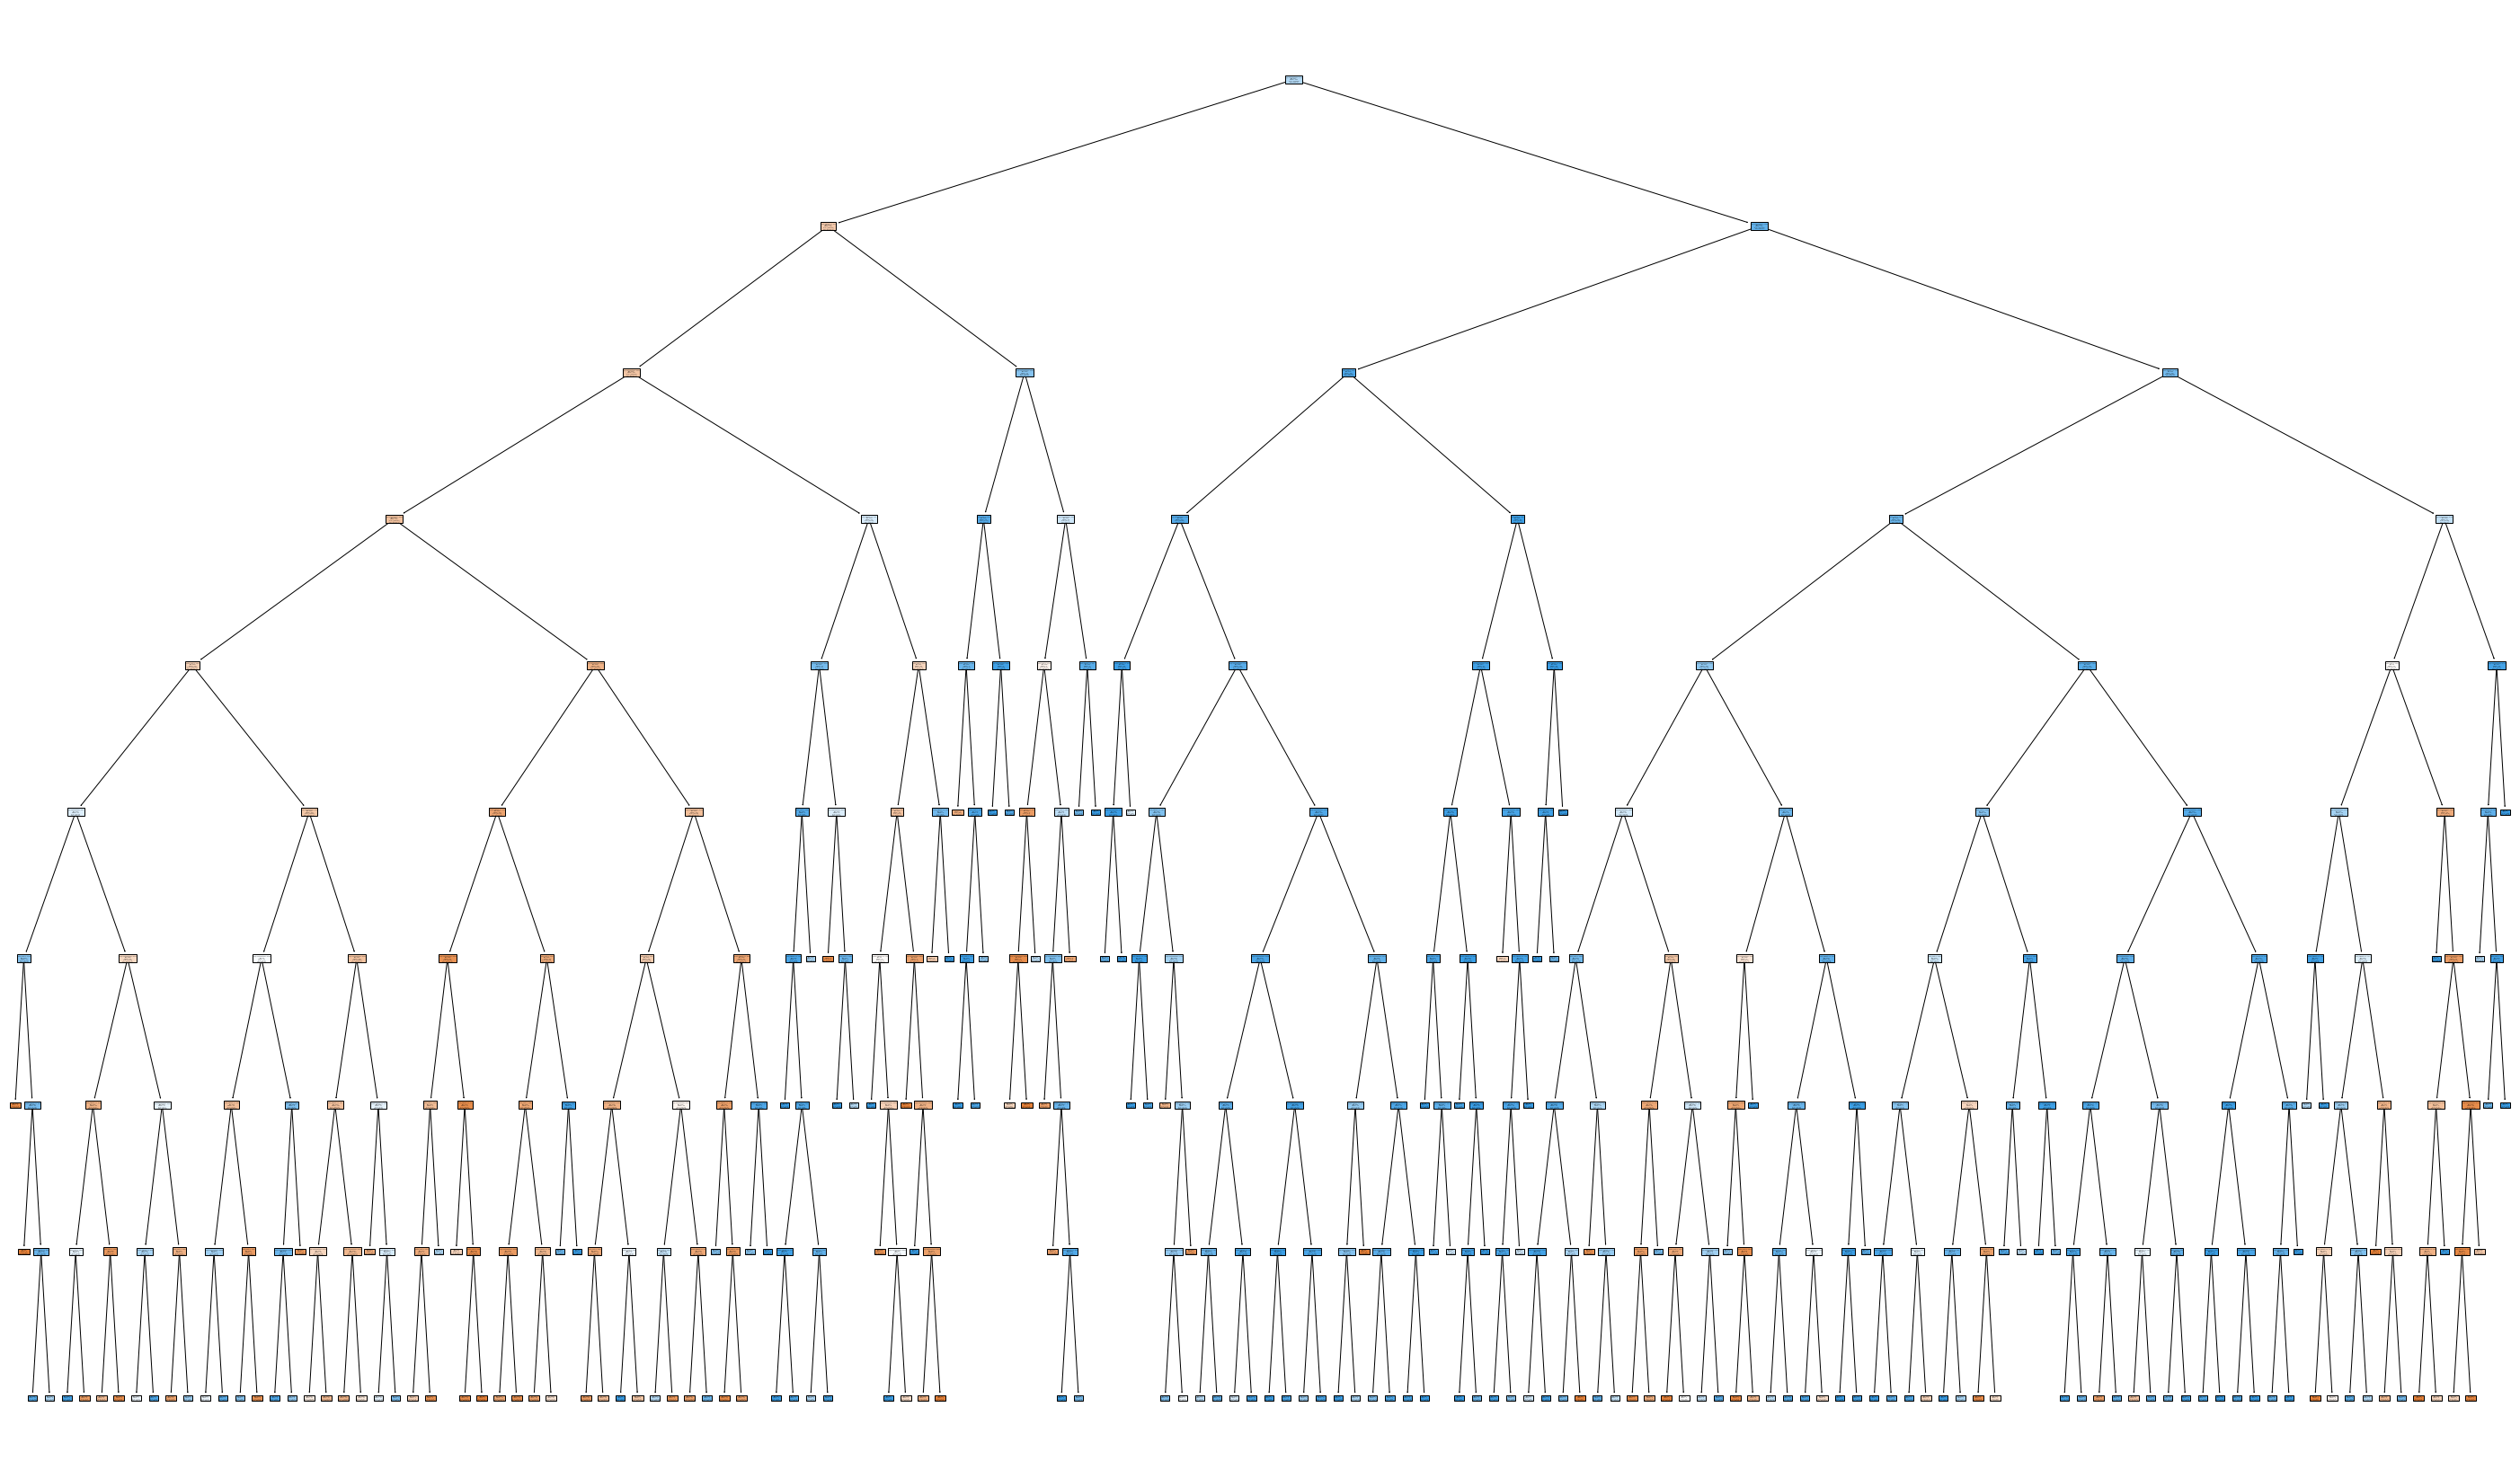

In [113]:
# Establish size of figure.
plt.figure(figsize = (50, 30))

# Plot our tree.
plot_tree(gs.best_estimator_,
          feature_names = X_train.columns,
          class_names = ['Not upwelling', 'Upwelling'],
          filled = True);